In [1]:
using LinearAlgebra
using LightGraphs
using MetaGraphs
using Polylogarithms
using Plots
using ForwardDiff
using Roots
using SpecialFunctions
using CSV
include("./Solutions to Homework 6/PSET6/GraphTraversals.jl")
using .GraphTraversals

In [80]:
using StatsBase

# Problem 1 

We have that $T_c = \frac{\sum_{k=1}^{\infty}kp_k}{\sum_{k=1}^{\infty}k(k-1)p_k} = \frac{\sum_{k=1}^{\infty}kp_k}{\sum_{k=1}^{\infty}k^2p_k - \sum_{k=1}^{\infty}kp_k} = \frac{\langle k \rangle}{\langle k^2 \rangle - \langle k \rangle} = \frac{1}{\frac{\langle k^2 \rangle}{\langle k \rangle} - 1} = \frac{1}{\kappa_0 - 1}$. Assuming that vaccination prevents an individual from either catching or spreading the disease, vaccinating with probability $v$ is equivalent to percolating with probability $v$; as a consequence the critical probability of having a giant component (i.e an epidemic) is $v_c = 1 - \frac{1}{\kappa_0 - 1} = 1 - T_c$. Consequently if $v > v_c$ then we lose the giant component (so there is no epidemic) and if $v < v_c$ we have a giant component (there is an epidemic). 

# Problem 2 

a) Setting $\alpha = 2.2$ we find the solution to $u = G_1(u) = \text{Li}_{\alpha-1}(u)/u\text{Li}_{\alpha-1}(1)$. The proportion of vertices in the giant component is: 

In [59]:
α = 2.2; 
G₀(x) = real(polylog(α, x)/polylog(α,1));
G₁(x) = real(polylog(α-1, x)/(x*polylog(α-1,1)));
f(x::Real) = G₁(x) - x;
#D(f)= x -> ForwardDiff.derivative(f,float(x)); 
S = 1 - find_zero(f, (0,0.5), FalsePosition())

0.8037364752242915

b) Setting $T = 0.4$, the proportion of vertices affected by the epidemic is computed by solving $u = G_1(1 - T + Tu)$ (part (a) is just the case $T=1$). 

In [37]:
T = 0.4;
f(x::Real) = G₁(1 - T + T*x) - x;
S = 1 - find_zero(f, (0,0.8), FalsePosition())
print("S = ",S); 

0.7117217936756421

Thus about 71% of the people are affected by the epidemic. 

c) Note that $\alpha < 3$ so $T_c = 0$ so there will always be an epidemic. As a consequence of part (a) we have that $v_c = 1.0$. So everybody will have to be vaccinated! Unfortunately, the probability of vaccinating a person these days is the probability that a vaccine is given to them times the probability that they will take the vaccine and the latter isn't always 1...

# Problem 3 

In [69]:
M = CSV.read("graph.csv", datarow=1);
M = convert(Array, M); 
G = Graph(M); 
G = MetaGraph(G);

{10000, 14259} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

a) Number of vertices in the giant component: 

In [75]:
DFSTree = GraphTraversals.my_dfs(G); 
sizes = get_prop(DFSTree, :cc_sizes);
print("|S| = ", maximum(sizes))

8172

Note that it provides us a check on the theoretical estimate derived in part (a) of Problem 2. 

b) The transmission graph also contains a giant component. The number of affected vertices:

In [158]:
Sick_Graph = deepcopy(G)
for edge in edges(G)
    infecting = sample([true,false], Weights([0.4,0.6]));
    if infecting 
        rem_edge!(Sick_Graph,edge);
        set_prop!(G,src(edge),dst(edge), :infecting, infecting); 
    else
        set_prop!(G,src(edge),dst(edge), :infecting, false); 
    end
end

In [86]:
DFSTree = GraphTraversals.my_dfs(Sick_Graph); 
sizes = get_prop(DFSTree, :cc_sizes);
maximum(sizes)

5640

c) Note that $T_c = 1/G'_{1}(1)$ i.e the reciprocal of the average number of second neighbours.

In [97]:
seconds = [];
for v in vertices(G)
    sns = 0.0; 
    for u in neighbors(G,v)
        sns = sns + length(neighbors(G,u)) - 1;
    end
    seconds = push!(seconds, sns); 
end
print("T_c = ", 1/mean(seconds))

T_c = 0.004839685420447671

d) Since $v_c = 1 - \frac{1}{\kappa - 1}$ we compute the $\kappa$ for the graph with epidemic and then its $v_c$.

In [102]:
k = 2*ne(Sick_Graph)/10000
seconds = [];
for v in vertices(Sick_Graph)
    sns = 0.0; 
    for u in neighbors(Sick_Graph,v)
        sns = sns + length(neighbors(Sick_Graph,u)) - 1;
    end
    seconds = push!(seconds, sns); 
end
kk = mean(seconds); 
print("v_c = ", 1 - 1/((kk/k) - 1))

v_c = 0.9800564643003383

# Problem 4

In [168]:
function getatts_edges(G::AbstractMetaGraph, attribute::String)
    atts = []; 
    for e in edges(G)
        prop = get_prop(G, src(e),dst(e), Symbol(attribute))
        atts = push!(atts, prop); 
    end
    return atts 
end

getatts_edges (generic function with 1 method)

We simulate the SIR model as follows: An initial node is infected at time $t = 1$; for all subsequent times $t$, each susceptible node to an infected node is infected with probability 0.4. An infected node flips to a recovered node after one time period of infection. Over a 100 trials, we found that most widespread infections infected about 30% of the population, so there was no epidemic. 

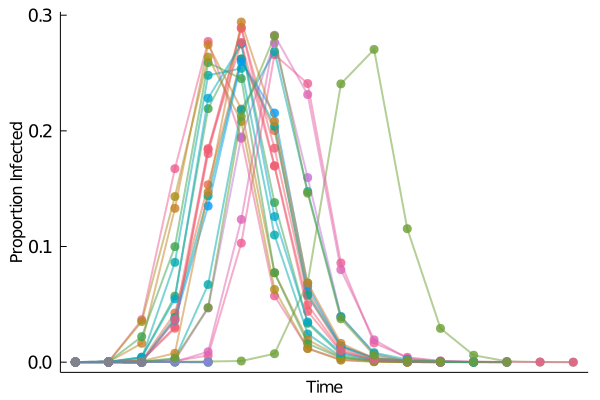

In [245]:
plot(); 
times = [];
for i in 1:100    
    for v in vertices(G)
        set_prop!(G,v,:susceptible, true); 
        set_prop!(G,v,:infected,  false); 
        set_prop!(G,v,:recovered, false); 
        set_prop!(G,v,:t_inf, 0); 
        set_prop!(G,v,:t_rec, 0); 
    end

    k = Int64(rand(1:1e4));
    set_prop!(G, k, :susceptible, false); 
    set_prop!(G, k, :infected, true); 
    time = 1;
    set_prop!(G, k,:t_inf,time);
    
    infecteds = Array{Float64,1}(undef,1);
    infecteds[1] = 1; 
    while sum(Int64.(GraphTraversals.getatts(G,"infected"))) > 0

        # Diagnostics
    #     print("\nDay ",time); 
    #     print("\nNumber Infected: ", sum(Int64.(GraphTraversals.getatts(G,"infected"))));
    #     print("\nNumber Recovered: ", sum(Int64.(GraphTraversals.getatts(G,"recovered")))); 
    #     print("\nNumber Susceptible: ",sum(Int64.(GraphTraversals.getatts(G,"susceptible"))));
    #     print("\n------------------------------------------------"); 

        time = time + 1; 

        #Time for fresh infection! 

        for v in vertices(G)

            #Time to retire the oldies: If this is the third time period that you're infecting, 
            #you're recovered and no longer infecting. 

            if get_prop(G,v,:infected) && time - get_prop(G,v,:t_inf) > 1
                set_prop!(G,v,:infected, false); 
                set_prop!(G,v,:recovered, true);
                set_prop!(G,v,:t_rec, time); 
            end

            #Time for fresh infection!! If you're infected and this isn't the time period that you
            #got infected, have a go! If your neighbour is susceptible and the infection die turns
            #in your favour, they get infected; they are no longer susceptible and their time stamp
            #is recorded. 

            if get_prop(G,v,:infected) && get_prop(G,v,:t_inf) < time 
                    for u in neighbors(G,v)
                        infecting = sample([true,false], Weights([0.4,0.6]));
                        if infecting && get_prop(G,u,:susceptible)
                            set_prop!(G,u,:infected,true);
                            set_prop!(G,u,:susceptible, false); 
                            set_prop!(G,u,:t_inf,time);
                        end
                    end
            end

        end
        
        infecteds = push!(infecteds, sum(Int64.(GraphTraversals.getatts(G,"infected")))); 
    end
    
    if i != 50
        plot!(infecteds./1e4,
            markershape = :circle, 
            #markersize = 2.0, 
            markerstrokewidth = 0,
            #linewidth = 2.0,
            linealpha = 0.5,
            markersize = 5.0,
            markeralpha = 0.8,
            gridalpha = 0,
            linewidth = 2.0);
    else
        Plots.display(plot!(infecteds./1e4,
                            markershape = :circle, 
                            gridalpha = 0,
                            linewidth = 2.0,
                            linealpha = 0.2,
                            markersize = 5.0,
                            markeralpha = 0.5,
                            ytickfontsize = 12,
                            xticks = false,
                            ylabel = "Proportion Infected",
                            xlabel = "Time",
                            legend = false,
                            markerstrokewidth = 0))
    end
    push!(times, time);
end

Furthermore, most infections lasted for less than $5$ time periods but about 40% (the ones that produced the most widespread infections) lasted for between 10 and 15 time periods. In the short spreads, the initial vertex was usually in the small components of the graph. The long spreads correspond to the initial vertex being in the giant component. 

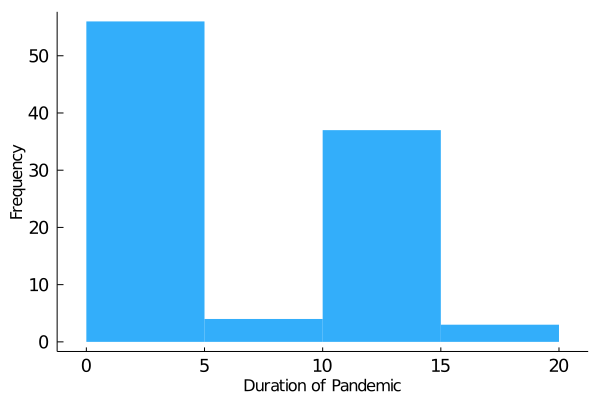

In [257]:
histogram(times, 
          bins = 5,
          legend = false,
          gridalpha = 0.0,
          ytickfontsize = 12, 
          xtickfontsize = 12,
          ylabel = "Frequency", 
          xlabel = "Duration of Pandemic",
          fillalpha = 0.8,
          linealpha = 0.0)

The relationship between BFS and SIR is as follows: Set $T=1$. Then in the second time period, the initial node infects all of its neighbours. In the third one, all these neighbours infect their neighbours except for the ones already infected, and so on. In other words, at time $t$, the infection spreads to all the susceptible (i.e. undiscovered) neighbours of the currently infected (discovered and active). Moreover, the chain of individuals to patient zero is at most $t$ persons long at time $t$, because at one time only the immediate neighbours of an infected vertex are infected (i.e explored). This process is exactly the Breadth First Search. Introducing $T < 1.0$ is essentially doing a Breadth First Search with "mistakes."  